In [1]:
import numpy as np
import random
import optuna
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
import json
import os
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

In [3]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)

In [4]:
def get_trend_changes_report_dict(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4,
        output_dict=True,
        zero_division=0
    )

def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [13]:
# Cargar datos
train = pd.read_csv("../../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set = pd.read_csv("../../../data/post_cleaning/test_set.csv", parse_dates=['date'])
X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=["date", "target_trend"]).values
y_test = test_set["target_trend"].values

In [14]:
def objective(trial):
    set_seeds(SEED)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 16)
    max_iter = trial.suggest_int("max_iter", 100, 500)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    l2_regularization = trial.suggest_float("l2_regularization", 0.0, 2.0)
    max_bins = trial.suggest_int("max_bins", 128, 255)

    model = HistGradientBoostingClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        max_iter=max_iter,
        min_samples_leaf=min_samples_leaf,
        l2_regularization=l2_regularization,
        max_bins=max_bins,
        random_state=SEED
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = trend_changes_true(y_val, y_pred)
    return score

In [15]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=300)

[I 2025-08-24 15:11:26,756] A new study created in memory with name: no-name-09f4f877-3664-49fd-9ccc-57f4e19f2c91
[I 2025-08-24 15:11:28,849] Trial 0 finished with value: 0.3561643835616438 and parameters: {'learning_rate': 0.01774894524799066, 'max_depth': 11, 'max_iter': 275, 'min_samples_leaf': 16, 'l2_regularization': 1.559951616237607, 'max_bins': 162}. Best is trial 0 with value: 0.3561643835616438.
[I 2025-08-24 15:11:32,725] Trial 1 finished with value: 0.273972602739726 and parameters: {'learning_rate': 0.022892239910869177, 'max_depth': 14, 'max_iter': 484, 'min_samples_leaf': 18, 'l2_regularization': 0.7156345399157333, 'max_bins': 192}. Best is trial 0 with value: 0.3561643835616438.
[I 2025-08-24 15:11:34,760] Trial 2 finished with value: 0.3380281690140845 and parameters: {'learning_rate': 0.07748288441159408, 'max_depth': 12, 'max_iter': 248, 'min_samples_leaf': 12, 'l2_regularization': 1.0061663306156194, 'max_bins': 129}. Best is trial 0 with value: 0.3561643835616438.

In [16]:
# Visualizar el historial de optimización
plot_optimization_history(study)

In [17]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de trend change: {study.best_value:.4f}")
best_params = study.best_params

Mejores hiperparámetros encontrados:
{'learning_rate': 0.01118292023836174, 'max_depth': 13, 'max_iter': 157, 'min_samples_leaf': 1, 'l2_regularization': 1.6240267168954154, 'max_bins': 189}
Mejor score de trend change: 0.4571


In [18]:
# Guardar los mejores hiperparámetros y su valor
history = []
if os.path.exists("best_hyperparams.json"):
    try:
        with open("best_hyperparams.json", "r") as f:
            history = json.load(f)
    except (json.JSONDecodeError, ValueError):
        history = []

# Guardar ambos en un solo diccionario
history.append({
    "params": study.best_params,
    "value": study.best_value
})
# Guardar el historial de hiperparámetros
with open("best_hyperparams.json", "w") as f:
    json.dump(history, f, indent=2)

In [12]:
# # Cargar historial de hiperparámetros y valores
# import json

# with open("best_hyperparams.json", "r") as f:
#     history = json.load(f)

# # Escoger el último (más reciente)
# best_params = history[-1]["params"]
# best_value = history[-1]["value"]

# # Si quieres ver todos:
# for i, entry in enumerate(history):
#     print(f"Hiperparámetros #{i+1}: {entry['params']}, Valor: {entry['value']}")

# # Si quieres escoger uno específico (por índice):
# # best_params = history[indice_que_quieras]["params"]
# # best_value = history[indice_que_quieras]["value"]

In [19]:
# Entrenar modelo final con los mejores hiperparámetros
set_seeds(SEED)
final_model = HistGradientBoostingClassifier(
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    max_iter=best_params["max_iter"],
    min_samples_leaf=best_params["min_samples_leaf"],
    l2_regularization=best_params["l2_regularization"],
    max_bins=best_params["max_bins"],
    random_state=SEED
)
final_model.fit(X_train, y_train)
y_val_pred = final_model.predict(X_val)
print("\nHistGradientBoostingClassifier Trend Changes Score:\n", trend_changes_score(y_val, y_val_pred))


HistGradientBoostingClassifier Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9300    0.9228    0.9264       259
        True     0.4444    0.4706    0.4571        34

    accuracy                         0.8703       293
   macro avg     0.6872    0.6967    0.6917       293
weighted avg     0.8736    0.8703    0.8719       293



In [20]:
y_pred_test = final_model.predict(X_test)
print("\nHistGradientBoostingClassifier Trend Changes Score:\n", trend_changes_score(y_test, y_pred_test))


HistGradientBoostingClassifier Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9187    0.8593    0.8880       263
        True     0.2292    0.3548    0.2785        31

    accuracy                         0.8061       294
   macro avg     0.5739    0.6071    0.5832       294
weighted avg     0.8460    0.8061    0.8237       294



In [21]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val, y_val_pred, digits=4)
print("Gradient Boosting Classifier Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))

Gradient Boosting Classifier Report:
               precision    recall  f1-score   support

          -1     0.8214    0.9787    0.8932        94
           0     0.7692    0.2439    0.3704        41
           1     0.9172    0.9748    0.9451       159

    accuracy                         0.8741       294
   macro avg     0.8359    0.7325    0.7362       294
weighted avg     0.8659    0.8741    0.8484       294

Balanced accuracy: 0.7324895368584357


In [22]:
# --- Exportar y Comparar Métricas de Modelos (Validación) ---

# 1. Definir el nombre del modelo actual y el archivo de salida
model_name = 'histGradientBoosting'
output_file = '../../../score_models/model_comparison_metrics.csv'

# 2. Calcular el reporte de clasificación estándar
# Usamos y_val_m y y_val_pred que están en la misma escala (0,1,2)
report_dict = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
precision = report_dict['macro avg']['precision']
recall = report_dict['macro avg']['recall']
f1_score = report_dict['macro avg']['f1-score']


# 3. Calcular el reporte de cambio de tendencia
report = get_trend_changes_report_dict(y_val, y_val_pred)
trend_change_precision = report['True']['precision']
trend_change_recall = report['True']['recall']
trend_change_f1_score = report['True']['f1-score']

# 4. Organizar las nuevas métricas
new_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'trend_change_precision': trend_change_precision,
    'trend_change_recall': trend_change_recall,
    'trend_change_f1_score': trend_change_f1_score
}

# 5. Cargar, actualizar y guardar el DataFrame de comparación
try:
    # Intentar cargar el archivo existente
    comparison_df = pd.read_csv(output_file, index_col='model')
    # Si existe, actualizar o añadir la fila para el modelo actual
    comparison_df.loc[model_name] = new_metrics
except FileNotFoundError:
    # Si no existe, crear un DataFrame nuevo directamente con los datos actuales
    comparison_df = pd.DataFrame([new_metrics], index=[model_name])

# Guardar el DataFrame actualizado en el CSV
comparison_df.to_csv(output_file, index_label='model')

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $14,635.95
Retorno Total de la Estrategia: 46.36%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


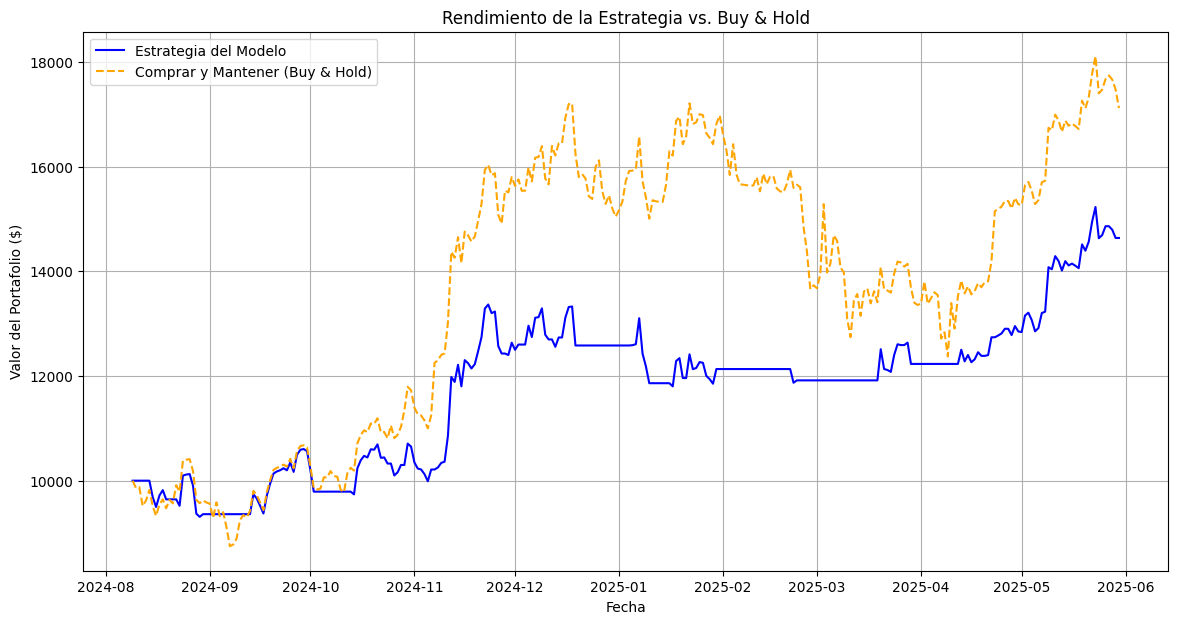

In [ ]:
# --- Preparación de Datos para Backtesting ---


# 2. Crear un DataFrame para el backtest
# Usamos una copia del test_set original que contiene precios y fechas
backtest_df = test_set.copy()
backtest_df['signal'] = y_pred_test

# La columna de precio que usaremos es la del día más reciente en la ventana deslizante
# Basado en tu notebook dataCleaning.ipynb, esta columna debería existir. 
# Si el nombre es diferente, ajústalo aquí.
price_col = [col for col in test_set.columns if 'open_d0' in col][-1]


# --- Simulación de Backtesting ---

initial_capital = 10000.0
cash = initial_capital
position = 0.0  # Unidades de BTC
portfolio_values = []

for i, row in backtest_df.iterrows():
    price = row[price_col]
    signal = row['signal']
    
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    
    # Calcular el valor actual del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df['portfolio_value'] = portfolio_values


# --- Cálculo de Métricas y Visualización ---

# 1. Calcular métricas de rendimiento
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("--- Resultados del Backtesting ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# 2. Visualizar los resultados
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')

# Normalizar el precio para comparar con "Buy & Hold"
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()